Check how many cores the GPU has

In [6]:
#The method automatically loads the images and uderstands the binary classification form the structure of the folders
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


------
-----
## Transfer learning approach


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
# import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

In [4]:
data_dir = "/home/ltarricone/ml4h_data/project1/chest_xray/chest_xray"


Some very basic data exploration (we can keep the one we already have)

In [5]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3876
['person1670_bacteria_4425.jpeg', 'person97_virus_181.jpeg', 'person936_virus_1598.jpeg', 'person54_bacteria_257.jpeg', 'person141_virus_287.jpeg']


In [6]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1342
['NORMAL2-IM-1096-0001-0003.jpeg', 'IM-0712-0001.jpeg', 'NORMAL2-IM-0947-0001.jpeg', 'NORMAL2-IM-1205-0001.jpeg', 'NORMAL2-IM-0718-0001.jpeg']


Data augmentation

In [7]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=T.Compose([T.Resize(260),                                     #to shrink down the image
                                            T.CenterCrop(224),                                 #to match the size of ResNet and at the same crop out the outside of the image 
                                            T.RandomHorizontalFlip(),                          #because we don't want a left-right bias
                                            T.RandomRotation(10),                              #to have rotational invariance features
                                            T.ToTensor(),                                       #because the model takes torch.Tensors as input
                                           # T.Normalize(mean=[0.485, 0.456, 0.406],           #to match the standardization of 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

Some quality checks

In [10]:
img, label = dataset[54]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


In [13]:
img[0,60:70,60:70]

tensor([[0.1647, 0.1686, 0.1647, 0.1804, 0.1686, 0.1686, 0.1686, 0.1647, 0.1529,
         0.1608],
        [0.1647, 0.1608, 0.1647, 0.1843, 0.1647, 0.1569, 0.1882, 0.2078, 0.1922,
         0.1647],
        [0.2039, 0.2078, 0.2000, 0.2078, 0.2196, 0.1882, 0.2588, 0.2706, 0.2902,
         0.2588],
        [0.2902, 0.3059, 0.2902, 0.2902, 0.2980, 0.2824, 0.2706, 0.2745, 0.3020,
         0.2980],
        [0.2824, 0.3137, 0.2980, 0.2784, 0.2667, 0.2745, 0.2549, 0.2588, 0.2863,
         0.2784],
        [0.2706, 0.3020, 0.3020, 0.2824, 0.2745, 0.2706, 0.2667, 0.2863, 0.3059,
         0.2784],
        [0.2431, 0.2784, 0.2980, 0.2941, 0.2863, 0.2745, 0.2667, 0.3137, 0.3176,
         0.2941],
        [0.2510, 0.2745, 0.3020, 0.3020, 0.3020, 0.2941, 0.3098, 0.3216, 0.3137,
         0.2902],
        [0.2588, 0.2902, 0.3176, 0.3216, 0.3294, 0.3333, 0.3412, 0.3255, 0.3294,
         0.3216],
        [0.3176, 0.3490, 0.3451, 0.3529, 0.3608, 0.3490, 0.3451, 0.3686, 0.3490,
         0.3529]])

In [7]:
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


Label:  NORMAL (0)


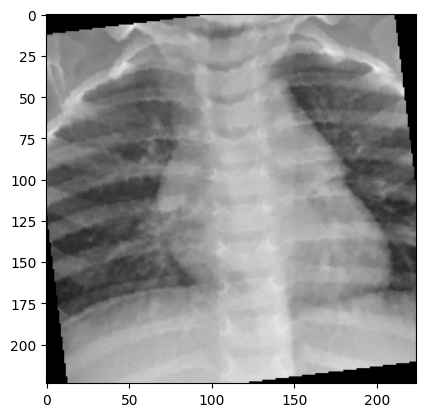

In [8]:
%matplotlib inline 

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[38])

Good to see that with our preprocessing we have cut out teh big majority of potentianl source of bias and we focus on the center of the torax

In [9]:
random_seed = 2024
torch.manual_seed(random_seed);

Here we ignore the given validation set becasue too small and we do as standard split with the training set

In [10]:
train_size = round(len(dataset)*0.8) # 80%
val_size = len(dataset) - train_size # 20%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4173, 1043)

In [11]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=1, pin_memory=True)

We inspect one batch of the Datalader

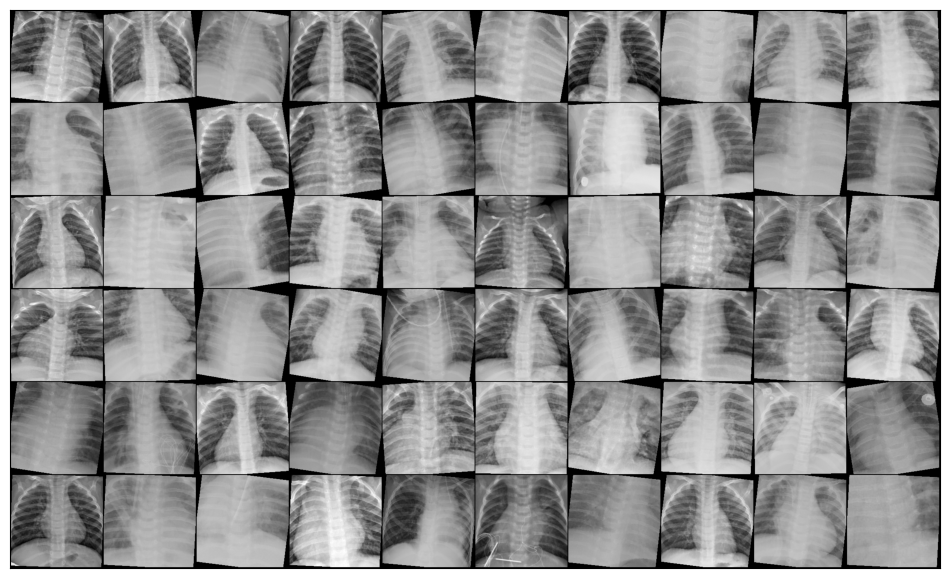

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [13]:
#Set device
device = torch.device('cuda')
device

device(type='cuda')

In [14]:
class DeviceDataLoader():

    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield self.to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)


In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
#functions to calculate the performance of the model

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

Creation and training of the model

In [17]:
class PneumoniaModelBase(nn.Module):
    """
    Base class that will have all the useful methods for the training of the model
    """
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [18]:
#downloading ResNet50
resnet50 = models.resnet50(weights=True)

/home/ltarricone/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)
    

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
#    Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

#     Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
#   sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients  
            
#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 13:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

/home/ltarricone/jupyter/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [22]:
epochs = 17
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [23]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

print('Best loss is:', best_loss)

bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet.pth')

# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


Epoch [1], train_loss: 0.1420, train_acc: 0.9335, val_loss: 0.0731, val_acc: 0.9714
Epoch [2], train_loss: 0.0645, train_acc: 0.9751, val_loss: 0.0892, val_acc: 0.9690
Epoch [3], train_loss: 0.0487, train_acc: 0.9825, val_loss: 0.0768, val_acc: 0.9681
Epoch [4], train_loss: 0.0414, train_acc: 0.9853, val_loss: 0.0508, val_acc: 0.9852
Epoch [5], train_loss: 0.0277, train_acc: 0.9893, val_loss: 0.1033, val_acc: 0.9679
Epoch [6], train_loss: 0.0231, train_acc: 0.9917, val_loss: 0.0462, val_acc: 0.9861
Epoch [7], train_loss: 0.0198, train_acc: 0.9941, val_loss: 0.0807, val_acc: 0.9714
Epoch [8], train_loss: 0.0284, train_acc: 0.9884, val_loss: 0.0953, val_acc: 0.9688
Epoch [9], train_loss: 0.0227, train_acc: 0.9922, val_loss: 0.0443, val_acc: 0.9835
Epoch [10], train_loss: 0.0132, train_acc: 0.9948, val_loss: 0.0757, val_acc: 0.9794
Epoch [11], train_loss: 0.0174, train_acc: 0.9924, val_loss: 0.1008, val_acc: 0.9635
Epoch [12], train_loss: 0.0233, train_acc: 0.9920, val_loss: 0.0414, val_a

In [20]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./PneumoniaResnet.pth')

In [28]:
model.to(device)

PneumoniaResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [29]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [30]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=T.Compose([T.Resize(260),
                                                 T.CenterCrop(224),                                                              
                                                 T.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [31]:
test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.4980, test_acc: 0.8808


<Figure size 640x480 with 0 Axes>

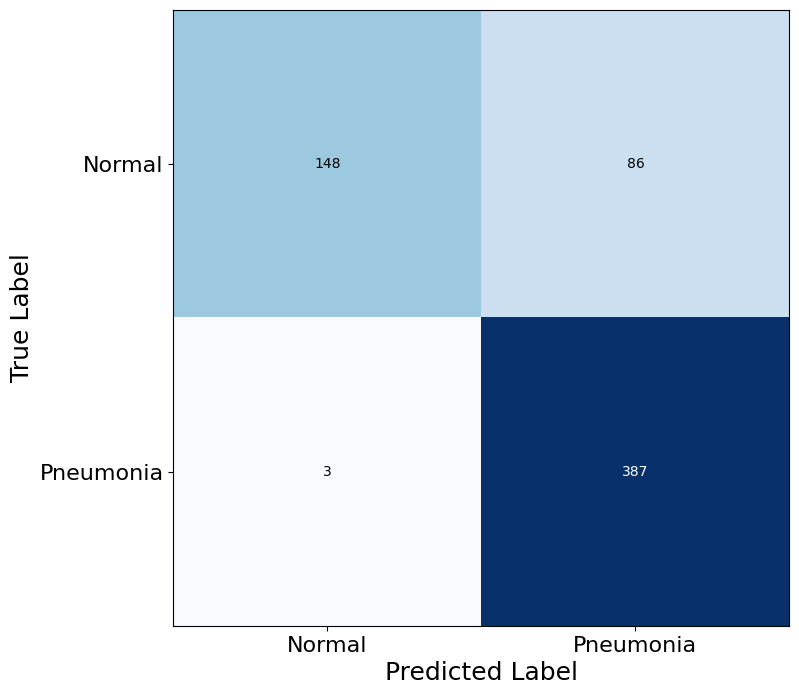

In [32]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [33]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.86
Recall of the model is 0.99
Precision of the model is 0.82
F1 Score of the model is 0.90
